# Plik roboczy

In [4]:
using Plots
using IJulia
using LinearAlgebra
gr()

Plots.GRBackend()

rungekutta4 - źródło kodu:
https://perso.crans.org/besson/publis/notebooks/Runge-Kutta_methods_for_ODE_integration_in_Julia.html

In [5]:
function rungekutta4(f, u0, t; ω = 4π, ball_radius::Real = 0.12, 
                          rim_x_front::Real = 4, rim_x_back::Real = 4.54,
                          rim_y::Real = 3.059, rim_radius::Real = 0.009)
    n = length(t)
    u = zeros((n, length(u0)))
    u[1,:] = u0
    fronts = zeros(Bool, n)
    backs = zeros(Bool, n)
    boards = zeros(Bool, n)
    for i in 1:n-1
        h = t[i+1] - t[i]
        k1 = f(u[i,:], t[i]; ω = ω)
        k2 = f(u[i,:] + k1 * h/2, t[i] + h/2; ω = ω)
        k3 = f(u[i,:] + k2 * h/2, t[i] + h/2; ω = ω)
        k4 = f(u[i,:] + k3 * h, t[i] + h; ω = ω)
        x, ẋ, y, ẏ, ω, α = u[i,:] + (h/6) * (k1 + 2*k2 + 2*k3 + k4)
        if is_collision(x, y; rim_x = rim_x_front)
            fronts[i + 1] = true
            if !fronts[i]
                #ẋ, ẏ = rotate_coordinates(ẋ, ẏ, collision_angle(x, y, rim_x_front, rim_y))
            end
        elseif is_collision(x, y; rim_x = rim_x_back)
            backs[i + 1] = true
            if !backs[i]
                #ẋ, ẏ = rotate_coordinates(ẋ, ẏ, collision_angle(x, y, rim_x_back, rim_y))
            end
        end
        u[i + 1, :] = [x, ẋ, y, ẏ, ω, α]
    end
    return u
end

rungekutta4 (generic function with 1 method)

In [6]:
function euler(f, y_0, t; ω = 4π)
    n = length(t)
    y = zeros((n, length(y_0)))
    y[1, :] = y_0
    hit = nothing
    actual_hit = nothing
    for i in 1:n-1
        h = t[i + 1] - t[i]
        (k, hit, ω) =  f(y[i, :], t[i]; hit = hit, ω = ω)
        if actual_hit != hit
            y[i + 1, :] = k
        else
            y[i+1, :] = y[i, :] + h * k
        end
        actual_hit = deepcopy(hit)
    end
    return y
end

euler (generic function with 1 method)

## Równania ruchu piłki

https://indico.cern.ch/event/163205/contributions/1413227/attachments/192775/270516/Team351.pdf

$\begin{align}    
    &\text{Siła ciężkości:}  &&F_g = -mg\hat{y} \\
    &\text{Siła wyporu:}  &&F_w = \rho V g \,\hat{y} = B \, \hat{y} \\
    &\text{Siła oporu powietrza:} &&F_o = -\tfrac{1}{2}C_d\rho A v^2 \hat{v} = -bv^2\hat{v} = -b(\dot{x}^2 + \dot{y}^2)^{\frac{1}{2}}(\dot{x}\hat{x} + \dot{y}\hat{y})\\
    &\text{Siła Magnusa:} &&F_M = C_M \rho D^3 \bar{\omega} \times \bar{v} = c \, \bar{\omega} \times \bar{v} = -c \, \omega \dot{y}\hat{x} + c \, \omega \dot{x}\hat{y}\\
\end{align}$

$$ \begin{cases} m\ddot{x} = -b(\dot{x}^2 + \dot{y}^2)^{\frac{1}{2}}\dot{x} - c\,\omega\,\dot{y} \\
m\ddot{y} = -mg + B -b(\dot{x}^2 + \dot{y}^2)^{\frac{1}{2}}\dot{y} + c\,\omega\,\dot{x} \end{cases}$$

In [7]:
is_collision(ball_x::Real, ball_y::Real; ball_radius::Real = 0.12,
             rim_x::Real = 4, rim_y::Real = 3.09, rim_radius::Real = 0.04) = 
    sqrt((ball_x - rim_x) ^ 2 + (ball_y - rim_y) ^ 2) <= ball_radius + rim_radius

is_collision (generic function with 1 method)

In [8]:
function collision_angle(ball_x::Real, ball_y::Real, rim_x::Real, rim_y::Real)
    return angle(ball_y - rim_y + (rim_x - ball_x)im)
end

collision_angle (generic function with 1 method)

In [9]:
function rotate_coordinates(x::Real, y::Real, θ::Real; clockwise = false)
    if clockwise
        θ *= -1
    end
    return inv([cos(θ) -sin(θ); sin(θ) cos(θ)]) * [x; y]
end

rotate_coordinates (generic function with 1 method)

In [10]:
ẋ_after_collision(ẋ::Real, ω::Real, ball_radius::Real) = 3ẋ / 5 + 2ω * ball_radius / 5

ẋ_after_collision (generic function with 1 method)

In [11]:
angular_velocity(ẋ::Real, ball_radius::Real) = ẋ / ball_radius

angular_velocity (generic function with 1 method)

In [12]:
backboard_collision(ball_x::Real, ball_y::Real; ball_radius::Real = 0.12,
                    backboard_x::Real = 4.58, backboard_y_min::Real = 3.05, backboard_y_max::Real = 4.12) = 
    abs(backboard_x - ball_x) <= ball_radius && backboard_y_min <= ball_y <= backboard_y_max

backboard_collision (generic function with 1 method)

In [114]:
# u = [x, x', y, y']
# u' = [x', x'', y', y'']

g = 9.81
m = 0.623
c = 0.00381
B = 0.0784
b = 0.026

function basketball_throw(u, t; ω = 4π, k = 45000, p = 24, μ_b = 0.6, μ = 0.5, R = 0.12,
                          board_x::Real = 4.58, rim_x_front = 4, rim_x_back = 4.54, rim_y = 3.09, rim_radius = 0.04)
    if backboard_collision(u[1], u[3])
        uₓ = u[1] + R - board_x
        return [u[2], (-k * uₓ - p * u[2] - b * sqrt(u[2]^2 + u[4]^2) * u[2] - c * u[5] * u[4]) / m,
                u[4], (-sign(u[4]) * abs(μ_b * (-k * uₓ - p * u[2]))- m * g + B - b * sqrt(u[2]^2 + u[4]^2) * u[4] + c * u[5] * u[2]) / m,
                (R - uₓ) / (2/3 * m * R^2) * -sign(u[4]) * abs(μ_b * (-k * uₓ - p * u[2])), 0]
    elseif is_collision(u[1], u[3]; rim_x = rim_x_front)
        x, y = -b * sqrt(u[2]^2+u[4]^2) * u[2] - c * u[5] * u[4], - m * g + B - b * sqrt(u[2]^2+u[4]^2) * u[4] + c * u[5] * u[2]
        ϕ = collision_angle(u[1], u[3], rim_x_front, rim_y)
        ẋ, ẏ = rotate_coordinates(u[2], u[4], ϕ)
        uₕ = (R + rim_radius - sqrt((u[1] - rim_x_front) ^ 2 + (u[3] - rim_y) ^ 2)) / 2
        ẋ, ẏ = rotate_coordinates(-sign(ẋ) * abs(μ * (k * uₕ + p * ẏ)), k * uₕ + p * ẏ, ϕ; clockwise = true)
        [u[2], (ẋ + x) / m,
         u[4], (ẏ + y) / m,
         (R - uₕ) / (2/3 * m * R^2) * ẋ, 0]
    elseif is_collision(u[1], u[3]; rim_x = rim_x_back)
        x, y = -b * sqrt(u[2]^2+u[4]^2) * u[2] - c * u[5] * u[4], - m * g + B - b * sqrt(u[2]^2+u[4]^2) * u[4] + c * u[5] * u[2]
        ϕ = collision_angle(u[1], u[3], rim_x_back, rim_y)
        ẋ, ẏ = rotate_coordinates(u[2], u[4], ϕ)
        uₕ = (R + rim_radius - sqrt((u[1] - rim_x_back) ^ 2 + (u[3] - rim_y) ^ 2)) / 2
        ẋ, ẏ = rotate_coordinates(-sign(ẋ) * abs(μ * (k * uₕ + p * ẏ)), k * uₕ + p * ẏ, ϕ; clockwise = true)
        [u[2], (ẋ + x) / m,
         u[4], (ẏ + y) / m,
         (R - uₕ) / (2/3 * m * R^2) * ẋ, 0]
    else
        return [u[2], (- b * sqrt(u[2]^2 + u[4]^2) * u[2] - c * u[5] * u[4]) / m,
                u[4], (- m * g + B - b * sqrt(u[2]^2 + u[4]^2) * u[4] + c * u[5] * u[2]) / m,
                0, 0]
    end
end

basketball_throw (generic function with 1 method)

$$ \dot{x} = v_0\cos{\theta_0} $$
$$ \dot{y} = v_0\sin{\theta_0} $$

In [14]:
# absolute parameters (given in meters)

free_throw_line_x  = 3.96  # measured from the front edge of the rim
rim_y = 3.05
rim_diameter  = 0.46
ball_diameter = 0.2387
score_error = (rim_diameter - ball_diameter) / 2

# relative parameters (given in meters)

players_height = 1.91;

In [59]:
v₀ = 8.8
θ₀ = 40
rθ₀ = θ₀ / 180 * π  # [rad]

x₀ = 0
time = 3 # [seconds]
u₀ = [x₀; v₀ * cos(rθ₀); players_height; v₀ * sin(rθ₀); 4π; 0]
tspan = range(0, stop=time, length=time * 1000 + 1) # [time*60 - miliseconds]
sol = rungekutta4(basketball_throw, u₀, tspan);
#sol = euler(basketball_throw, u₀, tspan)

In [68]:
sol[740:760, 5]

21-element Array{Float64,1}:
 12.566370614359172
 12.566370614359172
 12.566370614359172
 12.566370614359172
 12.566370614359172
 12.566370614359172
 12.566370614359172
 12.566370614359172
 12.566370614359172
 14.158292875407945
 18.2779990497574  
 24.321498379946984
 31.69135140738431 
 39.809470473575495
 48.137677068144974
 56.177503049194854
 63.461234132777335
 69.54715316712337 
 74.02855654526019 
 76.55995618265699 
 76.89676637751764 

In [18]:
rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])

function visualize_throw(sol, distance, t)
    
    plot( # trajectory
        sol[1:t,1], 
        sol[1:t,3], 
        xlims=[0,distance + 1], 
        ylims=[0, max(sol[:, 3]..., rim_y + 1.07)], 
        linestyle=:dash, 
        legend = :none,
        color=:royalblue1
        )
    
    plot!( # rim
        rectangle(0.62, 0.08,
        distance, rim_y), 
        opacity=.7, 
        color= :orangered1
        )
    
    plot!( # pole
        rectangle(0.1, rim_y, distance  + 0.6, 0), 
        opacity=.5, 
        color=:grey
        )
    
    plot!( # net
        Shape([distance + 0.6 - 0.55, distance + 0.6, distance + 0.6 - 0.2, distance + 0.6 - 0.45], 
                [rim_y, rim_y, rim_y - 0.5, rim_y - 0.5]), 
        color=:white, 
        opacity = .3, 
        aspect_ratio=:equal
        )   
    
    plot!( # rim
        rectangle(0.02, 1.07,
        distance + 0.62, rim_y), 
        opacity=.7, 
        color= :black
        )
    
end

visualize_throw (generic function with 1 method)

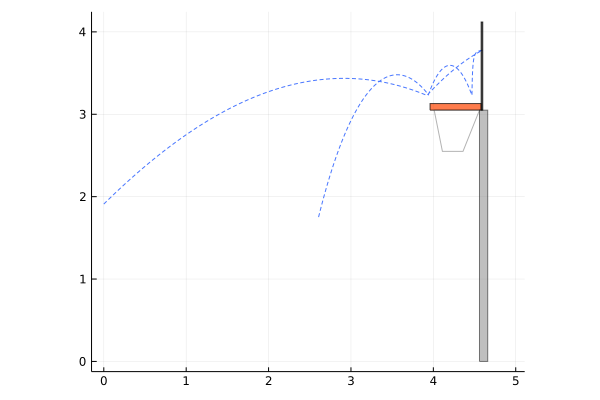

In [20]:
visualize_throw(sol, free_throw_line_x, 3001)

In [375]:
max(sol[:, 5]...), min(sol[:, 5]...), 4pi

(12.572161633085322, 12.566370614359172, 12.566370614359172)

In [376]:
sol[end, 5]

12.568786352548404

In [16]:
function animate_throw(distance, v₀, θ₀, ω, h, t)
    rθ₀ = θ₀ / 180 * π  # [rad]

    x₀ = 0
    u₀ = [x₀; v₀ * cos(rθ₀); h; v₀ * sin(rθ₀); ω; 0]
    tspan = range(0, stop=t, length=t*1000 + 1)
    sol = rungekutta4(basketball_throw, u₀, tspan);
    #sol = euler(basketball_throw, u₀, tspan)
    simulation = @animate for i ∈ 1:(t*1000 + 1)
                    visualize_throw(sol, distance, i)
                    scatter!( # ball
                            [sol[i, 1]], 
                            [sol[i, 3]], 
                            markersize=10, 
                            label="", 
                            color=:darkorange1
                            )
        end every 25
    return gif(simulation, "simulation.gif", fps = 40)
end

animate_throw (generic function with 1 method)

┌ Info: Saved animation to 
│   fn = C:\Users\mikil\Desktop\ODE-project\simulation.gif
└ @ Plots C:\Users\mikil\.julia\packages\Plots\c4EAv\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\mikil\\Desktop\\ODE-project\\simulation.gif")
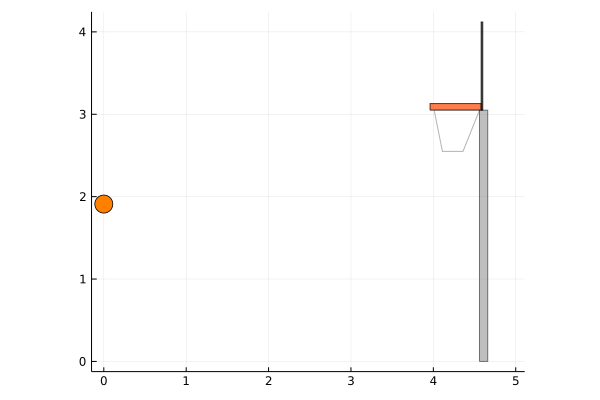

In [115]:
animate_throw(free_throw_line_x, 8.8, 40, 4π, 1.91, 2)

┌ Info: Saved animation to 
│   fn = C:\Users\mikil\Desktop\ODE-project\simulation.gif
└ @ Plots C:\Users\mikil\.julia\packages\Plots\c4EAv\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\mikil\\Desktop\\ODE-project\\simulation.gif")
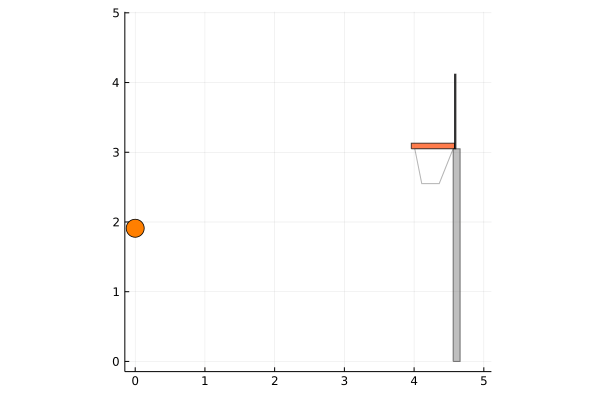

In [116]:
animate_throw(free_throw_line_x, 8.8, 66, 4π, 1.91, 3)

┌ Info: Saved animation to 
│   fn = C:\Users\mikil\Desktop\ODE-project\simulation.gif
└ @ Plots C:\Users\mikil\.julia\packages\Plots\c4EAv\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\mikil\\Desktop\\ODE-project\\simulation.gif")
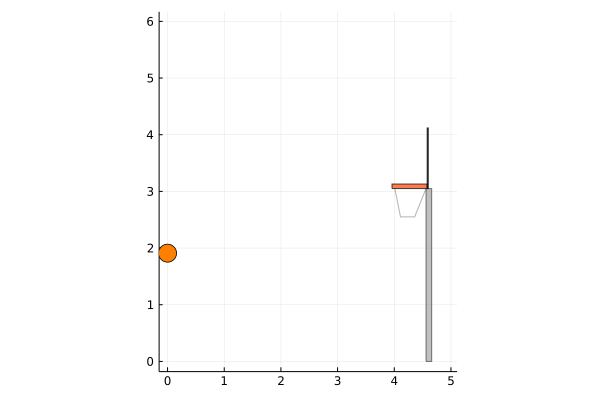

In [117]:
animate_throw(free_throw_line_x, 8.6, 65, 4π, 1.91, 3)

## Szukanie wartości początkowych v₀ i θ₀ dla których rzut jest celny - symulacja

Rzut celny: 

współrzędna y piłki ~= współrzędna y środka obręczy piłki

oraz

współrzędna x piłki ± margines błędu = współrzędna x środka obręczy

In [60]:
function rungekutta4_basic(f, y0, t)
    n = length(t)
    y = zeros((n, length(y0)))
    y[1,:] = y0
    for i in 1:n-1
        h = t[i+1] - t[i]
        k1 = f(y[i,:], t[i])
        k2 = f(y[i,:] + k1 * h/2, t[i] + h/2)
        k3 = f(y[i,:] + k2 * h/2, t[i] + h/2)
        k4 = f(y[i,:] + k3 * h, t[i] + h)
        y[i+1,:] = y[i,:] + (h/6) * (k1 + 2*k2 + 2*k3 + k4)
    end
    return y
end

rungekutta4_basic (generic function with 1 method)

In [30]:
findnearest(A::AbstractArray, t) = findmin(abs.(A.-t))
good_x(x::Number, distance::Number, ε::Number) = (x > distance - ε) &&  (x < distance + ε) ? true : false
good_y(y::Number, rim_y::Number, ε::Number) = (y > rim_y - ε) && (y < rim_y) ? true : false

good_y (generic function with 1 method)

In [31]:
function scored(sol, distance, rim_y, rim_diameter, ball_radius, x₀, ε)
    for point in zip(sol[:, 1], sol[:, 3])
        x, y = point[1], point[2]
        if good_x(x, distance - x₀ + rim_diameter/2, ε) && good_y(y, rim_y, ball_radius/2)
            return true
        end
    end
    return false
    end    

scored (generic function with 1 method)

In [36]:
function throws_simulation(vₘᵢₙ, vₘₐₓ, θₘᵢₙ, θₘₐₓ, 
                            points, time, distance, 
                            players_height, ε;
                            x₀ = 0,
                            rim_y = 3.05,
                            ball_radius=0.11935, 
                            rim_diameter=0.46,
                            collisions=true,
                            ω₀ = 4π)
    
    good_v₀s = Array{Float64,1}()
    good_θ₀s = Array{Float64,1}()
    
    v₀s   = range(vₘᵢₙ, stop=vₘₐₓ, length=points)
    θ₀s   = range(θₘᵢₙ, stop=θₘₐₓ, length=points) ./ 180 .* π
    tspan = range(0,   stop=time, length=time*1000)
    
    collisions ? solve = rungekutta4 : solve = rungekutta4_basic
    
    for θ₀ in θ₀s
        for v₀ in v₀s 
            u₀ = [x₀; v₀ * cos(θ₀); players_height; v₀ * sin(θ₀); 4π; 0] 
            global ω = ω₀
            sol = solve(basketball_throw, u₀, tspan)
            if scored(sol, distance, rim_y, rim_diameter, ball_radius, x₀, ε)
                push!(good_v₀s, v₀)
                push!(good_θ₀s, θ₀)
            end
        end
    end
    return good_v₀s, good_θ₀s ./ π .* 180
end

throws_simulation (generic function with 1 method)

In [357]:
x, y = throws_simulation(5, 10, 30, 80, 200, 2, free_throw_line_x, 1.91, score_error, collisions=false)

UndefVarError: UndefVarError: rungekutta4_basic not defined

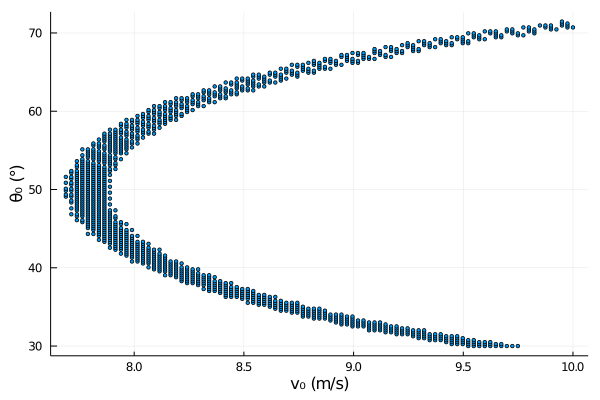

In [65]:
scatter(x, y, markersize=2, xlabel="v₀ (m/s)", ylabel="θ₀ (°)", label="")

In [33]:
x, y = throws_simulation(5, 10, 30, 80, 00, 2, free_throw_line_x, 1.91, score_error, collisions=true)

(Float64[], Float64[])

In [43]:
x, y = throws_simulation(5, 10, 30, 80, 00, 3, free_throw_line_x, 1.91, score_error, collisions=true)

([9.848484848484848, 9.646464646464647, 9.545454545454545, 9.090909090909092, 8.484848484848484, 8.434343434343434, 8.232323232323232, 8.181818181818182, 8.383838383838384, 8.131313131313131  …  9.747474747474747, 9.797979797979798, 9.94949494949495, 10.0, 9.494949494949495, 9.848484848484848, 9.8989898989899, 9.94949494949495, 9.94949494949495, 10.0], [31.010101010101014, 33.535353535353536, 34.04040404040404, 36.56565656565657, 40.101010101010104, 43.131313131313135, 43.63636363636363, 44.14141414141414, 44.14141414141414, 44.64646464646464  …  69.8989898989899, 69.8989898989899, 69.8989898989899, 69.8989898989899, 70.4040404040404, 70.4040404040404, 70.4040404040404, 70.4040404040404, 70.90909090909092, 70.90909090909092])

In [118]:
x, y = throws_simulation(5, 10, 30, 80, 200, 3, free_throw_line_x, 1.91, score_error, collisions=true)

([9.874371859296483, 9.949748743718592, 9.673366834170855, 9.773869346733669, 9.673366834170855, 9.321608040201005, 9.447236180904522, 9.371859296482413, 9.321608040201005, 9.246231155778894  …  9.949748743718592, 9.974874371859297, 9.899497487437186, 9.924623115577889, 9.949748743718592, 9.974874371859297, 10.0, 9.974874371859297, 10.0, 9.949748743718592], [32.01005025125628, 32.51256281407035, 32.76381909547739, 33.266331658291456, 33.76884422110553, 34.2713567839196, 35.02512562814071, 35.527638190954775, 35.778894472361806, 36.28140703517588  …  70.45226130653266, 70.45226130653266, 70.7035175879397, 70.7035175879397, 70.7035175879397, 70.7035175879397, 70.7035175879397, 70.95477386934672, 70.95477386934672, 71.20603015075378])

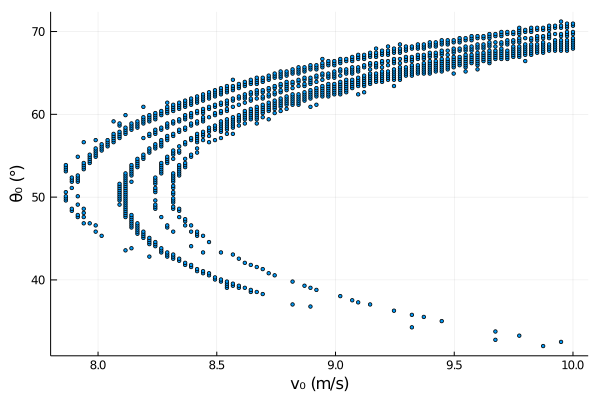

In [120]:
scatter(x, y, markersize=2, xlabel="v₀ (m/s)", ylabel="θ₀ (°)", label="")

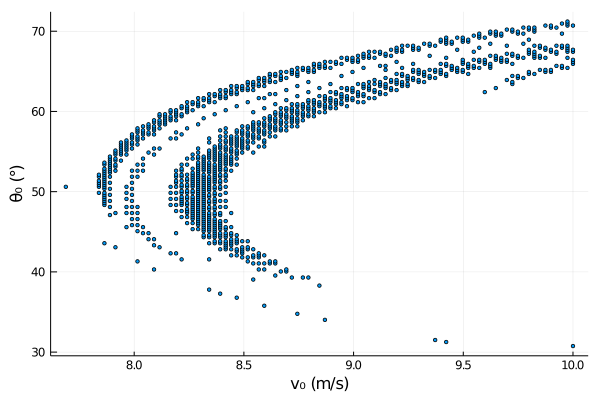

In [359]:
scatter(x, y, markersize=2, xlabel="v₀ (m/s)", ylabel="θ₀ (°)", label="")

# Symulacja dla ustalonego kąta i zmiennej prędkości kątowej

In [90]:
function throws_simulation2(θ, vₘᵢₙ, vₘₐₓ, ωₘᵢₙ, ωₘₐₓ, 
                            points, time, distance, 
                            players_height, ε;
                            x₀ = 0,
                            rim_y = 3.05,
                            ball_radius=0.11935, 
                            rim_diameter=0.46,
                            collisions=true)
    
    good_v₀s = Array{Float64,1}()
    good_ω₀s = Array{Float64,1}()
    
    v₀s   = range(vₘᵢₙ, stop=vₘₐₓ, length=points)
    ω₀s   = range(ωₘᵢₙ, stop=ωₘₐₓ, length=100)
    tspan = range(0,   stop=time, length=time*60)
    collisions ? solve = rungekutta4 : solve = rungekutta4_basic
    
    for ω₀ in ω₀s
        for v₀ in v₀s 
            global ω = ω₀
            u₀ = [x₀; v₀ * cos(θ); players_height; v₀ * sin(θ)]
            sol = solve(basketball_throw, u₀, tspan)
            if scored(sol, distance, rim_y, rim_diameter, ball_radius, x₀, ε)
                push!(good_v₀s, v₀)
                push!(good_ω₀s, ω₀)
            end
        end
    end
    return good_v₀s, good_ω₀s
end

throws_simulation2 (generic function with 3 methods)

In [91]:
x, y = throws_simulation2(π/4, 6, 9, 0, 20, 500, 2, free_throw_line_x, 1.91, score_error, collisions=false)

([7.917835671342686, 7.923847695390782, 7.929859719438878, 7.935871743486974, 7.94188376753507, 7.947895791583166, 7.953907815631262, 7.959919839679359, 7.965931863727455, 7.971943887775551  …  7.887775551102204, 7.8937875751503, 7.8997995991983965, 7.905811623246493, 7.9118236472945895, 7.917835671342686, 7.923847695390782, 7.929859719438878, 7.935871743486974, 7.94188376753507], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0])

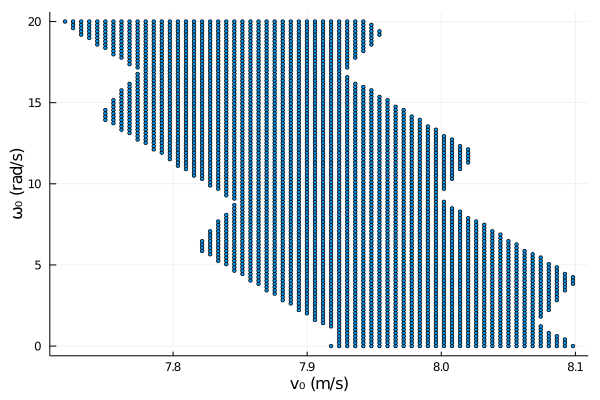

In [92]:
scatter(x, y, markersize=2, xlabel="v₀ (m/s)", ylabel="ω₀ (rad/s)", label="")

In [382]:
?quiver

search: quiver quiver!



```
quiver(x,y,quiver=(u,v))
quiver!(x,y,quiver=(u,v))
```

Make a quiver (vector field) plot. The `i`th vector extends from `(x[i],y[i])` to `(x[i] + u[i], y[i] + v[i])`.

# Example

```julia-repl
julia> quiver([1,2,3],[3,2,1],quiver=([1,1,1],[1,2,3]))
```


In [1]:
using PyPlot

In [11]:
x = range(-1, stop=1, length=10)
streamplot(x, x, x' .* ones(10), ones(10) .* x')

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= C:\Users\mikil\.julia\packages\PyCall\tqyST\src\pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'AttributeError'>
AttributeError("'list' object has no attribute 'ndim'")
  File "C:\Users\mikil\.julia\conda\3\lib\site-packages\matplotlib\pyplot.py", line 2978, in streamplot
    __ret = gca().streamplot(
  File "C:\Users\mikil\.julia\conda\3\lib\site-packages\matplotlib\__init__.py", line 1438, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
  File "C:\Users\mikil\.julia\conda\3\lib\site-packages\matplotlib\streamplot.py", line 86, in streamplot
    grid = Grid(x, y)
  File "C:\Users\mikil\.julia\conda\3\lib\site-packages\matplotlib\streamplot.py", line 317, in __init__
    if x.ndim == 1:


In [9]:
range(-1, stop=1, length=10) .* ones(5)'

10×5 Array{Float64,2}:
 -1.0       -1.0       -1.0       -1.0       -1.0     
 -0.777778  -0.777778  -0.777778  -0.777778  -0.777778
 -0.555556  -0.555556  -0.555556  -0.555556  -0.555556
 -0.333333  -0.333333  -0.333333  -0.333333  -0.333333
 -0.111111  -0.111111  -0.111111  -0.111111  -0.111111
  0.111111   0.111111   0.111111   0.111111   0.111111
  0.333333   0.333333   0.333333   0.333333   0.333333
  0.555556   0.555556   0.555556   0.555556   0.555556
  0.777778   0.777778   0.777778   0.777778   0.777778
  1.0        1.0        1.0        1.0        1.0     